<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

# PT-BR
Loggi é uma startup brasileira unicórnio com foco em logística. Inicialmente, no período entre 2013 e 2014, a empresa realizava entregas exclusivamente de documentos. Dois anos mais tarde, expandiu suas operações para o segmento de e-commerce e, desde 2017, tem se destacado também nas entregas de alimentos.

Este notebook tem como objetivo realizar uma análise exploratória de dados das entregas no Distrito Federal, buscando insights relevantes ao final do estudo.


---

# ENG

Loggi is a Brazilian unicorn startup with a focus on logistics. Initially, between 2013 and 2014, the company exclusively delivered documents. Two years later, it expanded into the e-commerce segment and has been involved in food deliveries since 2017.

This notebook aims to conduct an exploratory data analysis of deliveries in the Federal District, seeking valuable insights by the end of the study.

## 2\. Pacotes e bibliotecas

In [182]:
import json
import geopy
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


## 3\. Exploração de dados

# PT-BR

Os dados brutos são armazenados em um arquivo `JSON` que contém uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas a serem executadas pelos veículos do hub regional. Vejamos um exemplo:

---

# ENG

The raw data is stored in a JSON file that contains a list of delivery instances. Each instance represents a set of deliveries to be carried out by the vehicles from the regional hub. Let's take an example:

In [183]:
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...

Ellipsis

# PT-BR

**name**: uma string representando o nome único da instância;

**region**: uma string indicando o nome exclusivo da região do hub;

**origin**: um dicionário contendo as coordenadas de latitude e longitude da região do hub;

**vehicle_capacity**: um número inteiro representando a soma da capacidade de carga dos veículos do hub;

**deliveries**: uma lista de dicionários representando as entregas que precisam ser realizadas.

**id**: uma string representando o ID único da entrega;

**point**: um dicionário contendo as coordenadas de latitude e longitude da entrega;

**size**: um número inteiro representando o tamanho ou carga que a entrega ocupa no veículo.

---

# ENG


**name**: a string representing the unique name of the instance;

**region**: a string indicating the unique name of the hub's region;

**origin**: a dictionary containing the latitude and longitude coordinates of the hub's region;

**vehicle_capacity**: an integer representing the sum of the vehicle capacity of the hub;

**deliveries**: a list of dictionaries representing the deliveries to be carried out.

**id**: a string representing the unique ID of the delivery;

**point**: a dictionary containing the latitude and longitude coordinates of the delivery;

**size**: an integer representing the size or load that the delivery occupies in the vehicle.



# PT-BR

O dado bruto está disponível para download neste [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). Vamos realizar o seu download num arquivo `JSON` com o nome `deliveries.json`.

Vamos carregar os dados do arquivo em um dicionário Python chamado `data` e logo em seguida gerar um dataframe `deliveries_df`:

---

# ENG

The raw data is available for download at this [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). Let's download it into a JSON file named deliveries.json.

We will load the data from the file into a Python dictionary called data and then proceed to create a dataframe deliveries_df:


In [184]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

with open(file='deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file);

deliveries_df = pd.DataFrame(data)
deliveries_df.head(n=3)

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."


In [185]:
print(deliveries_df.keys())

Index(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'], dtype='object')


In [186]:
deliveries_df.dtypes

name                object
region              object
origin              object
vehicle_capacity     int64
deliveries          object
dtype: object

In [187]:
deliveries_df.isna().any()

name                False
region              False
origin              False
vehicle_capacity    False
deliveries          False
dtype: bool

#PT-BR

A estrutura dos dados na coluna "origin" e na coluna "deliveries" estão aninhados. A seguir, utilizaremos os métodos normalize e explode para formatá-los.

---

# ENG

The data in the "origin" column and the "deliveries" column is nested. Below, we will use the normalize and explode methods to format them.

In [188]:
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df.rename(columns={'lng': 'hub_lng', 'lat':'hub_lat'})
deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')

deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries': 'delivery_size'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries': 'delivery_lng'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries': 'delivery_lat'})
], axis=1)

deliveries_df = deliveries_df.drop('deliveries', axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True);
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055


## 4\. Manipulação

#PT-BR

A geocodificação é o processo que converte uma localização descrita por texto (endereço, nome do local, etc.) em suas coordenadas geográficas correspondentes (latitude e longitude). A geocodificação reversa realiza o oposto, convertendo coordenadas geográficas de um local em suas descrições textuais correspondentes.

Empresas como Google, Bing e Yahoo! oferecem serviços de geocodificação (com tarifas associadas). Existe um projeto de código aberto chamado OpenStreetMap que mantém um serviço gratuito de geocodificação conhecido como Nominatim. No entanto, esse serviço possui uma limitação, permitindo apenas uma única consulta por segundo. Vamos utilizá-lo por meio da biblioteca Python geopy para realizar a operação reversa e enriquecer nosso DataFrame principal.

---

#ENG

The process of geocoding involves transforming a location described by text (address, place name, etc.) into its respective geographical coordinates (latitude and longitude). On the other hand, reverse geocoding performs the opposite, converting geographic coordinates of a location into their corresponding textual descriptions.

Companies like Google, Bing, and Yahoo! provide geocoding services (with associated fees). There is an open-source project called OpenStreetMap that maintains a free geocoding service known as Nominatim. However, this service has a limitation, allowing only a single request per second. Let's use it through the Python library geopy to perform reverse geocoding and enrich our main DataFrame






In [189]:
geolocator = Nominatim(user_agent='ebac_geocoder')
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df = deliveries_df[['region', 'hub_lat', 'hub_lng']];
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)

hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ',' + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)

hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace=True)
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)

hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]

deliveries_df = pd.merge(left=deliveries_df, right= hub_df, how='inner', on='region')

deliveries_df.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat,hub_suburb,hub_city
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929,Taguatinga,Taguatinga
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772,Taguatinga,Taguatinga
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871,Taguatinga,Taguatinga
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471,Taguatinga,Taguatinga
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055,Taguatinga,Taguatinga


#PT-BR

Embora o hub contenha apenas 3 geolocalizações distintas, as entregas totalizam 636.149, o que demandaria aproximadamente 7 dias para serem consultadas no servidor do Nominatim, devido à restrição de uma consulta por segundo. No entanto, para cargas pesadas como essa, o software oferece uma opção de instalação local (em sua própria máquina), que pode ser utilizada sem restrições.

---
#ENG

While the hub contains only 3 distinct geolocations, the deliveries amount to a total of 636,149, which would take around 7 days to be queried on the Nominatim server, given the restriction of one request per second. However, for heavy workloads like this, the software offers a local installation option (on your own machine), which can be used without restrictions.

In [190]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [191]:
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [192]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat,hub_suburb,hub_city,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929,Taguatinga,Taguatinga,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772,Taguatinga,Taguatinga,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871,Taguatinga,Taguatinga,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471,Taguatinga,Taguatinga,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055,Taguatinga,Taguatinga,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [193]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   vehicle_capacity  636149 non-null  int64  
 3   hub_lng           636149 non-null  float64
 4   hub_lat           636149 non-null  float64
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   hub_suburb        636149 non-null  object 
 9   hub_city          636149 non-null  object 
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


In [194]:
deliveries_df.isna().any()

name                False
region              False
vehicle_capacity    False
hub_lng             False
hub_lat             False
delivery_size       False
delivery_lng        False
delivery_lat        False
hub_suburb          False
hub_city            False
delivery_city        True
delivery_suburb      True
dtype: bool

## 5\. Visualização

#PT-BR

Iremos empregar a biblioteca Geopandas em Python (link para a documentação) a fim de visualizar as coordenadas dos hubs e das entregas no mapa do Distrito Federal, segmentados pela região dos hubs. Essa biblioteca adiciona funcionalidades geoespaciais ao pacote Pandas em Python.

---

#ENG

We will use the Geopandas Python library (link to the documentation) to visualize the coordinates of the hubs and deliveries on the map of the Federal District, segmented by the region of the hubs. This library adds geospatial functionalities to the Python Pandas package.

In [195]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


<ipython-input-196-a996527625c3>:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


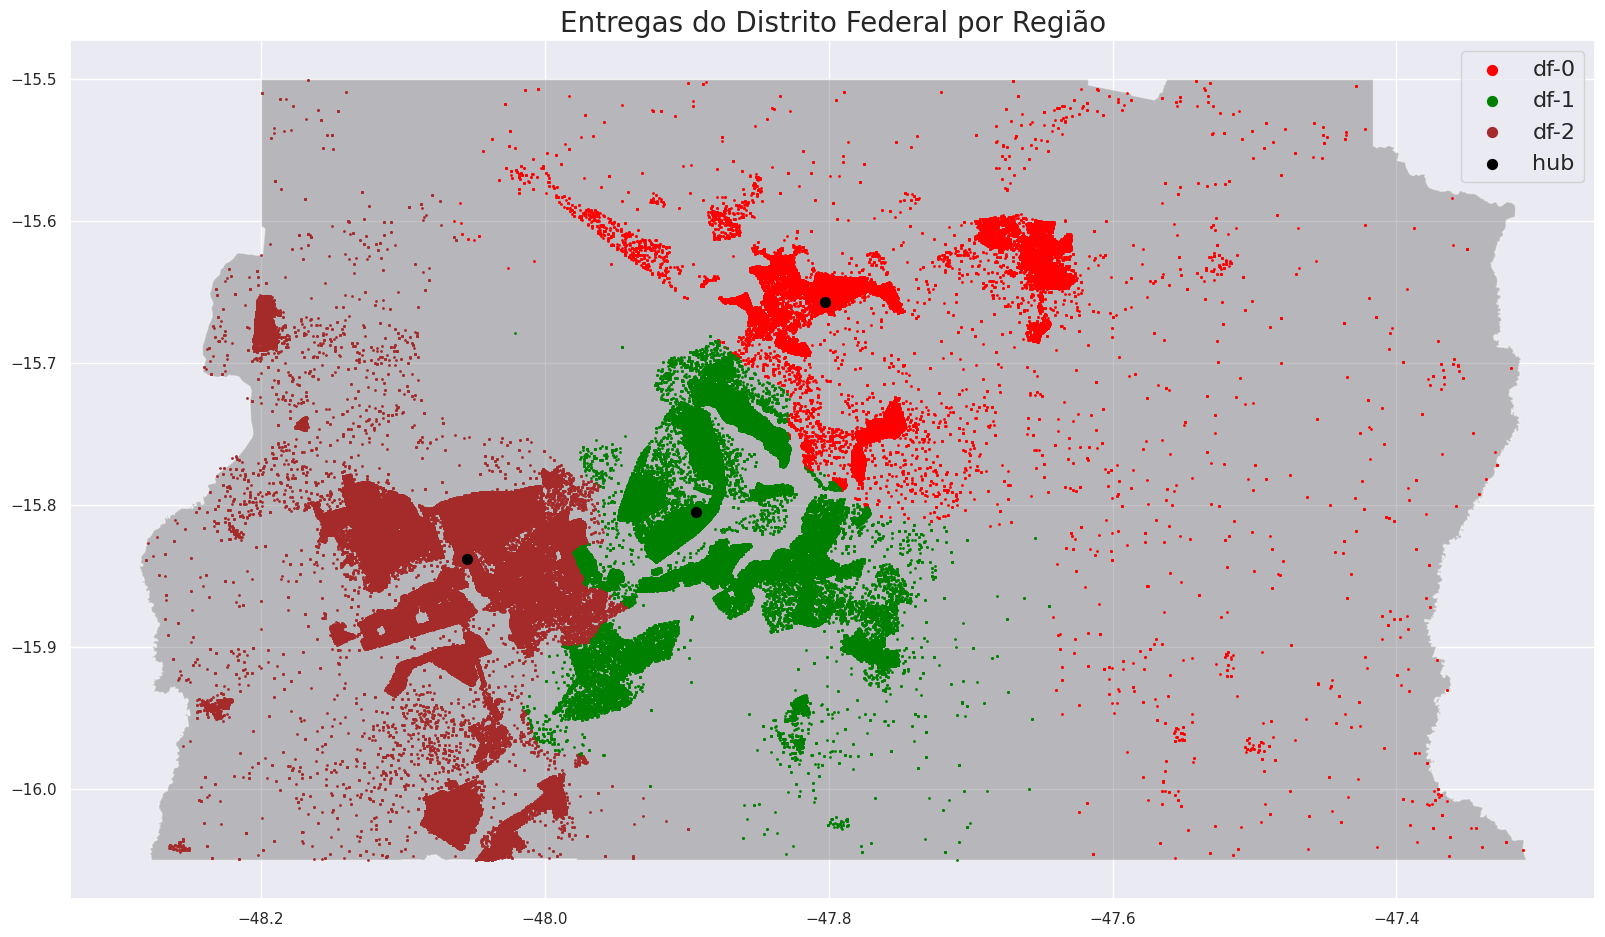

In [196]:
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa.head()

hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))


geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))


fig, ax, = plt.subplots(figsize = (50/2.54, 50/2.54))

mapa.plot(ax=ax, alpha=0.4, color='dimgrey')

geo_deliveries_df.query('region == "df-0"').plot(ax=ax, markersize=1, color='red', label='df-0')
geo_deliveries_df.query('region == "df-1"').plot(ax=ax, markersize=1, color='green', label='df-1')
geo_deliveries_df.query('region == "df-2"').plot(ax=ax, markersize=1, color='brown', label='df-2')

geo_hub_df.plot(ax=ax, markersize=50, marker='o', color='black', label='hub')

plt.title('Entregas do Distrito Federal por Região', fontdict={'fontsize': 20})
lgnd = plt.legend(prop={'size': 16})

for handle in lgnd.legendHandles:
  handle.set_sizes([50])

#INSIGHTS

#PT-BR

1. As entregas estão corretamente atribuídas aos seus respectivos hubs.
2. Os hubs das regiões 0 e 2 realizam entregas em locais distantes do centro e entre si, o que pode resultar em tempos e custos de entrega mais elevados.

---

#ENG

1. The deliveries are correctly allocated to their respective hubs.
2. The hubs in regions 0 and 2 make deliveries to locations far from the center and from each other, which may result in longer delivery times and higher costs.

<ipython-input-197-a12b30feef93>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data,x='region', y='region_percent',ci=None,palette='pastel')
<ipython-input-197-a12b30feef93>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data,x='region', y='region_percent',ci=None,palette='pastel')


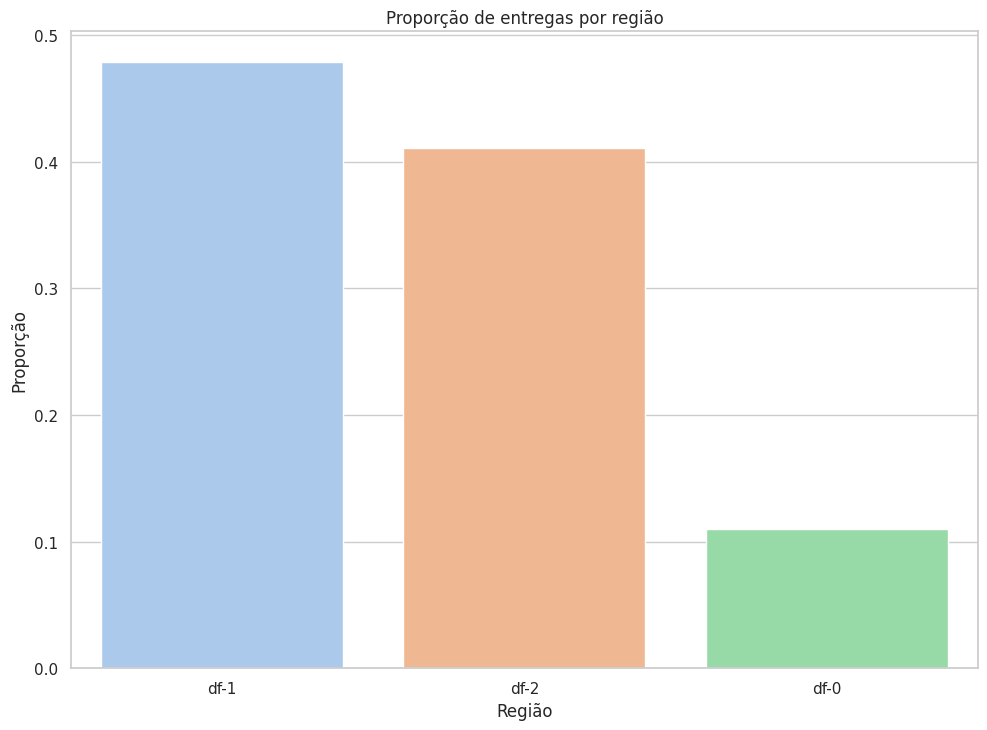

In [197]:
data  = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: 'region_percent'}, inplace=True)

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data,x='region', y='region_percent',ci=None,palette='pastel')
  grafico.set(title='Proporção de entregas por região',xlabel='Região', ylabel='Proporção')

#INSIGTS

#PT-BR

*   A distribuição das entregas está muito concentrada nos hubs das regiões 1 e 2, mas é baixa na região 0. No entanto, a capacidade dos veículos é a mesma para todos os hubs. Portanto, seria viável realocar os veículos para as regiões com maior demanda de tráfego.

---

#ENG

*   The distribution of deliveries is highly concentrated in the hubs of regions 1 and 2, but is low in region 0. However, the capacity of the vehicles is the same for all hubs. Therefore, it would be feasible to relocate the vehicles to regions with higher traffic demand.




<ipython-input-213-47b3379394c4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data_df_0, y='city', x='count', palette='pastel')


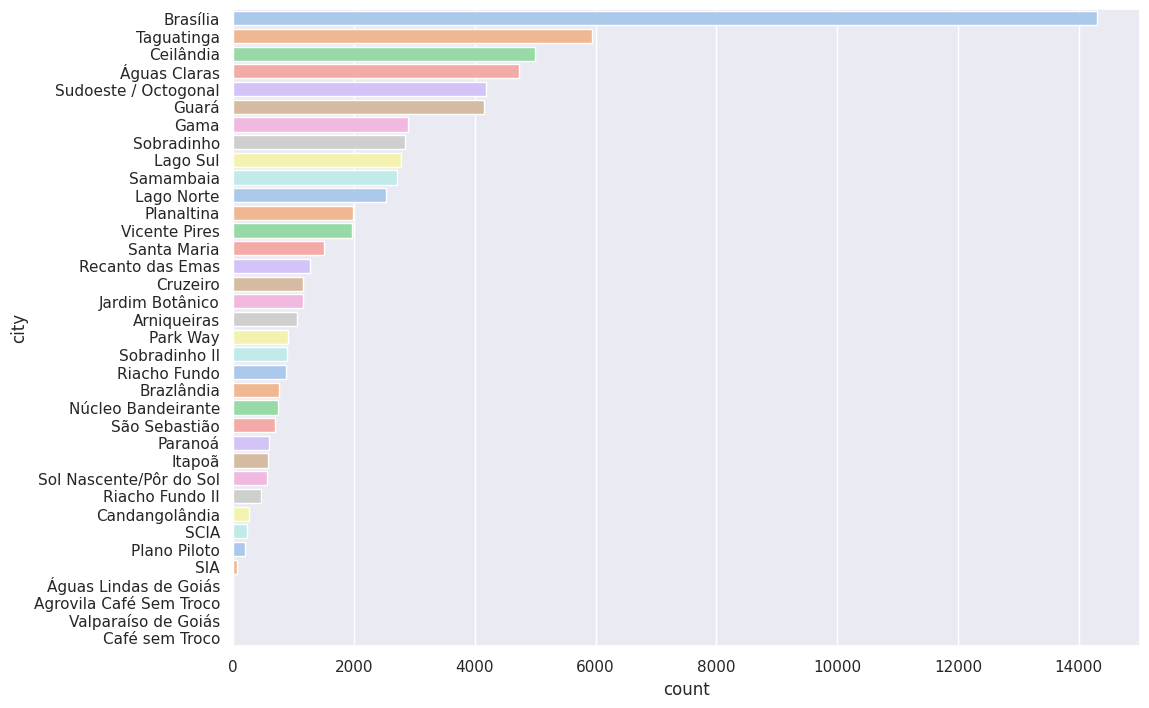

In [213]:
data_df_0 = deliveries_df.query('region == "df-0"')[ 'delivery_city'].value_counts().reset_index()
data_df_0 = data_df_0.rename(columns={'index': 'city', 'delivery_city': 'count'})
data_df_0


grafico = sns.barplot(data=data_df_0, y='city', x='count', palette='pastel')

#INSIGHTS

#PT-BR

O gráfico acima mostra que a cidade com o maior número de entregas, de longe, é Brasília, enquanto o hub da região está localizado em Sobradinho. Considerando apenas o fator dos locais de entrega, uma realocação da sede poderia ser uma escolha mais estratégica

---

#ENG

The chart above shows that the city with by far the most deliveries is Brasília, while the hub for the region is located in Sobradinho. Considering only the factor of delivery locations, a relocation of the headquarters could be a more strategic choice.